In [1]:
# Load dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/TRAINING_DATA.txt', sep='\t', header=None)
df.columns = ['label', 'text']

# ⚡ Verify label mapping
print("Label distribution:\n", df['label'].value_counts())


Label distribution:
 label
0    7464
1    7460
Name: count, dtype: int64


In [2]:
# ⚡ Simplified preprocessing - remove clean_text step temporarily
# from nlp_utils import clean_text
# df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['text']  # Bypass cleaning for debugging

In [3]:
# Split data properly
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [6]:
#  ⚡ Convert to HuggingFace Dataset
# %pip install datasets
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df[['cleaned_text', 'label']])
val_ds = Dataset.from_pandas(val_df[['cleaned_text', 'label']])
test_ds = Dataset.from_pandas(test_df[['cleaned_text', 'label']])

In [7]:
# ⚡ Spanish-optimized model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dccuchile/distilbert-base-spanish-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ⚡ Batch tokenization with proper truncation
def tokenize_fn(batch):
    return tokenizer(
        batch['cleaned_text'],
        padding='max_length',
        truncation=True,
        max_length=256  # Increased from 200
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/9551 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/2985 [00:00<?, ? examples/s]

In [8]:
# ⚡ Format datasets for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [13]:
# After tokenization, verify keys
print(train_ds[0].keys())  # Should only have: input_ids, attention_mask, label

dict_keys(['label', 'input_ids', 'attention_mask'])


In [14]:
# ⚡ Custom model with improved classifier head
from torch import nn
from transformers import DistilBertPreTrainedModel, DistilBertModel

class CustomDistilBert(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel(config)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, 256),
            nn.ReLU(),
            nn.Linear(256, config.num_labels)
        )
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # ⚡ Only pass input_ids and attention_mask to DistilBERT
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits}

model = CustomDistilBert.from_pretrained(model_name, num_labels=2)

Some weights of CustomDistilBert were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# ⚡ Enhanced training arguments
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import torch

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
import transformers
# ⚡ Improved trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    # ⚡ Add this to handle loss internally
    callbacks=[transformers.TrainerCallback]
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,1.330100,0.610433,0.675879,0.699767,0.673814
2,1.153700,0.602913,0.674623,0.695652,0.673062
3,0.991000,0.632950,0.671692,0.673877,0.671677
4,0.850000,0.711930,0.656198,0.696936,0.649871
5,0.733300,0.750396,0.650335,0.671130,0.648931
6,0.633300,0.801574,0.643635,0.655605,0.643204
7,0.564200,0.860105,0.644891,0.672587,0.642332
8,0.515500,0.904262,0.639866,0.667183,0.637423
9,0.454500,0.935548,0.636935,0.662252,0.634883


TrainOutput(global_step=1490, training_loss=0.7721096320440305, metrics={'train_runtime': 747.8682, 'train_samples_per_second': 127.71, 'train_steps_per_second': 1.992, 'total_flos': 6229283408139264.0, 'train_loss': 0.7721096320440305, 'epoch': 9.936454849498327})

In [18]:
# Final evaluation
test_results = trainer.evaluate(test_ds)
print("\nTest set performance:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Macro F1: {test_results['eval_f1_macro']:.4f}")


Test set performance:
Accuracy: 0.6784
F1 Score: 0.7026
Macro F1: 0.6762


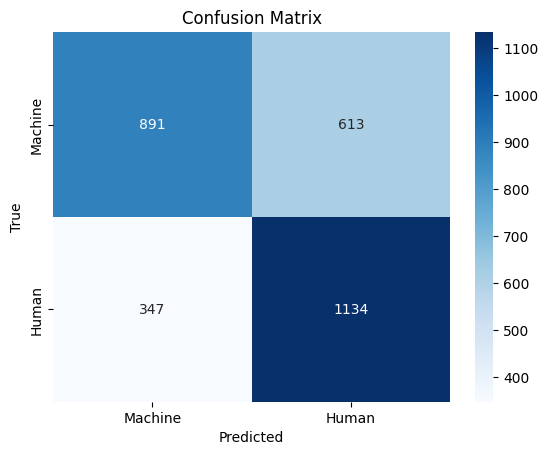

In [19]:
# ⚡ Error analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Machine', 'Human'],
            yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive folder path
drive_folder_path = '/content/drive/My Drive/Colab Notebooks/animals10 CNN Project/distilbert2'

# Save the model
model.save_pretrained(drive_folder_path)
tokenizer.save_pretrained(drive_folder_path)
trainer.save_model(drive_folder_path)

Mounted at /content/drive
